# Clustering
Regrouper des textes

In [1]:
# Import
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import spacy
# import datetime as dt
# from collections import Counter
# import seaborn as sns

In [2]:
# Import data
data_path = "../data/"
df = pd.read_pickle(data_path+"df_2017_avec_auteurs.pkl")

In [3]:
# Choix du corpus
dfh = df[df.rubrique.apply(lambda x : x in set(df.rubrique.head(5)))]
corpus = dfh.question
len(corpus)

1158

In [4]:
# Rubriques correspondantes sous forme d'entier
l_r = list(dfh.rubrique.unique())
dic_r = {l_r[i] : i for i in range(len(l_r))}
rubint = dfh.rubrique.apply(lambda x : dic_r[x])

In [5]:
# Groupes correspondants sous forme d'entier
l_g = list(dfh.groupe_auteur.unique())
dic_g = {l_g[i] : i for i in range(len(l_g))}
groupint = dfh.groupe_auteur.apply(lambda x : dic_g[x])

## A. TF et TFIDF

In [6]:
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

stop_words = get_stop_words('french')

# Calcul du TF-IF (pour brut, lsa, nmf ...)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Calcul du TF (pour LDA)
tf_vectorizer = CountVectorizer(stop_words=stop_words)
tf = tf_vectorizer.fit_transform(corpus)
tf_feature_names = tf_vectorizer.get_feature_names()

# Show part of result
samp = sample(range(len(tfidf_feature_names)),15)
docsamp = np.array([v[samp] for v in tfidf.toarray() if sum(v[samp])>0.0])
pd.DataFrame(docsamp,columns = np.array(tfidf_feature_names)[samp]).head(5)

,médecin,verre,secrétariat,l241,pocard,implicitement,signalement,colmar,christophe,veuf,17,détailler,déclinaison,chaotique,xavier
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083474,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.458057,0.000000,0.0,0.0,0.0,0.0
2,0.081200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.074961,0.0,0.0,0.0,0.0
4,0.117884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


## B. Brut : Clustering en s'apuyant sur la matrice des tf-idf ou des occurrences directement

## B.1 k-means
Prendre un corpus de documents, vectoriser avec tf idf, kmeans dessus. 
* From https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/
* Voir https://scikit-learn.org/stable/modules/clustering.html pour clustering on python

### B.1.1 Calcul du k-means

In [7]:
from sklearn.cluster import MiniBatchKMeans
random_state = 0
kmeans_brut = MiniBatchKMeans(n_clusters=5, random_state=random_state)
kmeans_brut.fit(tfidf);

### B.1.2 Calcul de l'ACP et affichage

In [8]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features_brut = pca.fit_transform(tfidf.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers_brut = pca.transform(kmeans_brut.cluster_centers_)

# Affichage des mots principaux de la pca
# ordre0 = abs(pca.components_)[0].argsort()[::-1]
# ordre1 = abs(pca.components_)[1].argsort()[::-1]
# nbb = 10
# print([vec.get_feature_names()[i] for  i in ordre0[:nbb]],"\n ============== \n",
# [vec.get_feature_names()[i] for  i in ordre0[-nbb:]],"\n ============== \n",
# [vec.get_feature_names()[i] for  i in ordre1[:nbb]],"\n ============== \n",
# [vec.get_feature_names()[i] for  i in ordre1[-nbb:]])

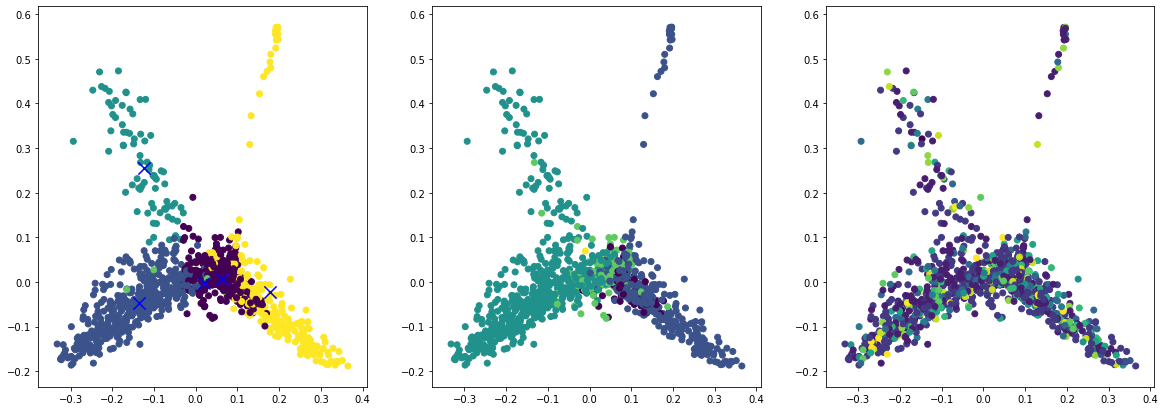

In [9]:
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_brut[:,0], reduced_features_brut[:,1], c=kmeans_brut.predict(tfidf))
axes[0].scatter(reduced_cluster_centers_brut[:, 0], reduced_cluster_centers_brut[:,1], marker='x', s=150, c='b')
axes[1].scatter(reduced_features_brut[:,0], reduced_features_brut[:,1], c=rubint)
axes[2].scatter(reduced_features_brut[:,0], reduced_features_brut[:,1], c=groupint)

## B.2 Ward HAC
https://chrisalbon.com/machine_learning/clustering/agglomerative_clustering/

### B.2.1 Clustering hac

In [10]:
# Create meanshift object
from sklearn.cluster import AgglomerativeClustering
agg_clust_brut = AgglomerativeClustering(linkage='complete', 
                              affinity='euclidean', 
                              n_clusters=3)

# Train model
agg_clust_brut = agg_clust_brut.fit(tfidf.toarray())

### B.2.2 ACP et affichage

In [11]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features_brut = pca.fit_transform(tfidf.toarray())

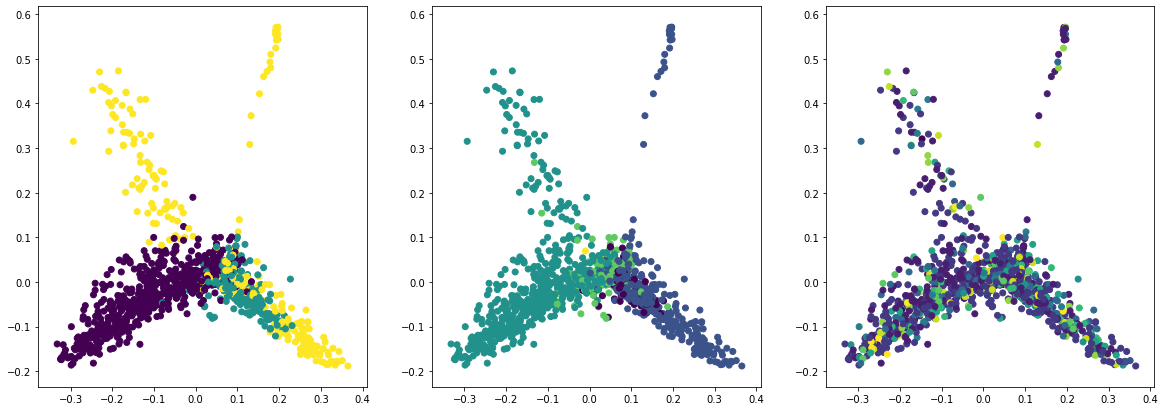

In [12]:
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_brut[:,0], reduced_features_brut[:,1], c=agg_clust_brut.labels_)
axes[1].scatter(reduced_features_brut[:,0], reduced_features_brut[:,1], c=rubint)
axes[2].scatter(reduced_features_brut[:,0], reduced_features_brut[:,1], c=groupint)

In [13]:
# Dendogramme associé
# from scipy.cluster.hierarchy import dendrogram, linkage
# Z = linkage(tfidf.toarray());
# dendrogram(Z);

# C. Clusetring avec décompositions de matrices
## C.3 Ananlyse Sémantique Latente LSA

### C.3.1 Décomposition en valeurs singulières

In [14]:
from sklearn.decomposition import TruncatedSVD

dim_lsa = 10 # Pas bon du tout, tenter de voir les meilleures valeurs singulières
svd_model = TruncatedSVD(n_components=dim_lsa, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(tfidf.T)
lsa_topics = svd_model.fit_transform(tfidf)

### C.3.2 Affichage des topics repérés

In [15]:
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(tfidf_feature_names, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ",end= ' ')
    for t in sorted_terms:
        print(t[0],end=' ')
    print('')

Topic 0:  maladie santé charge prise cancer patient pouvoir 
Topic 1:  service carte ant gris titre usager préfecture 
Topic 2:  cancer école enfant euro million pédiatrique compte 
Topic 3:  école compte administration million euro impayer maladie 
Topic 4:  social français étranger sécurité régime cotisation fraude 
Topic 5:  lyme tique test dépistage diagnostic protocole plan 
Topic 6:  alzheimer plan maladie enfant financement million pmnd 
Topic 7:  diabète diabétique métier alzheimer type accès atteindre 
Topic 8:  français étranger france diabète consulaire diabétique permettre 
Topic 9:  fibromyalgie alzheimer dépistage colorectal france femme trouble 


### C.3.3 Clustering et affichage (umap et acp)

In [16]:
# K-means
k_kmeans_lsa = 10
kmeans_lsa = MiniBatchKMeans(n_clusters=k_kmeans_lsa, random_state=random_state)
kmeans_lsa.fit(lsa_topics);

In [17]:
# UMAP
from umap import UMAP
embedding = UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(lsa_topics)

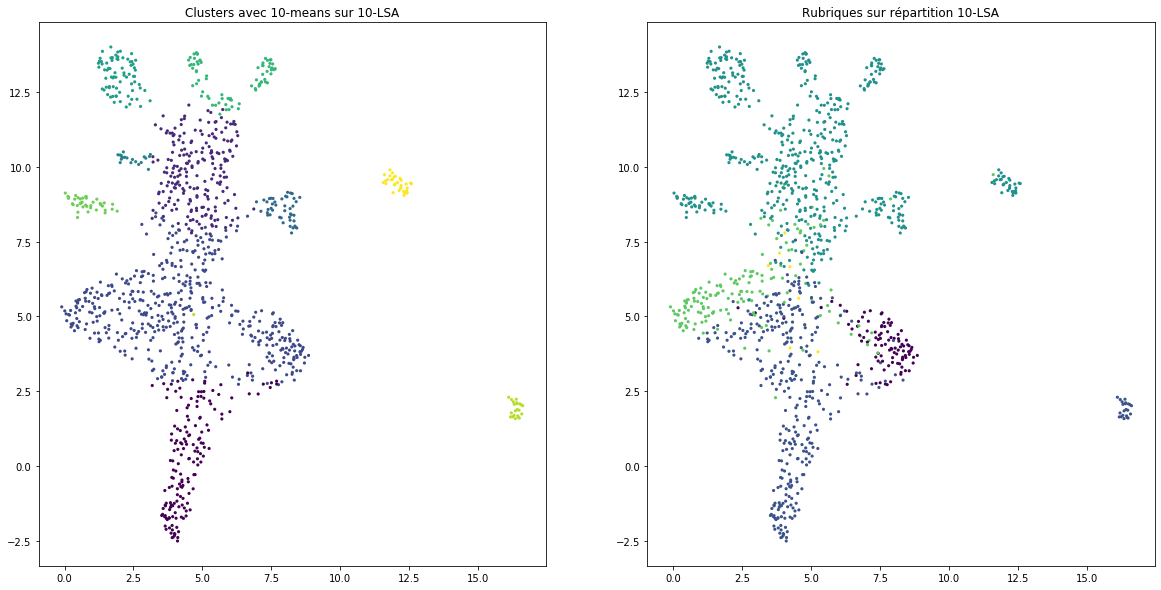

In [18]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(embedding[:, 0], embedding[:, 1], 
    c = kmeans_lsa.predict(lsa_topics),
    s = 10, # size
    edgecolor='none')
axes[0].set_title("Clusters avec {}-means sur {}-LSA".format(k_kmeans_lsa,dim_lsa));
axes[1].scatter(embedding[:, 0], embedding[:, 1], 
    c = rubint,
    s = 10, # size
    edgecolor='none')
axes[1].set_title("Rubriques sur répartition {}-LSA".format(dim_lsa));

In [19]:
# ACP
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features_lsa = pca.fit_transform(lsa_topics)

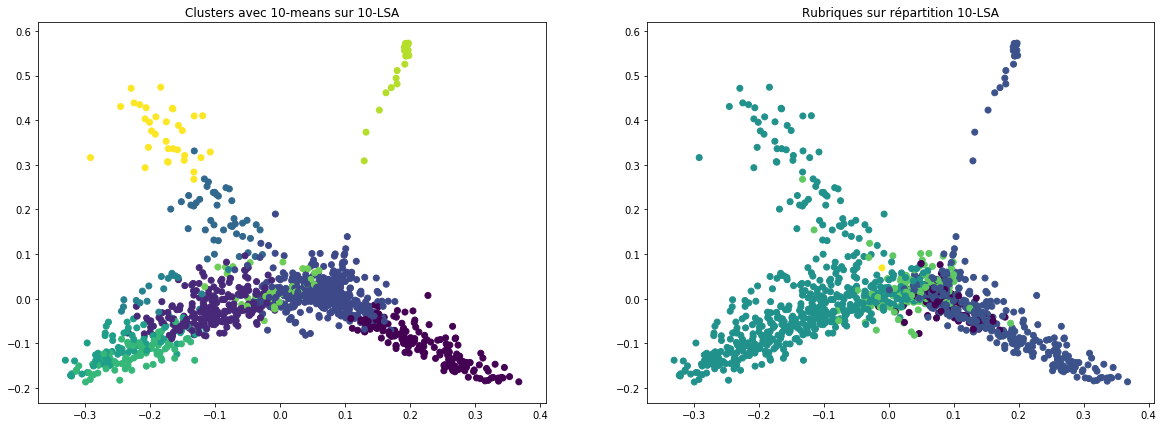

In [20]:
fig, axes = plt.subplots(1,2,figsize = (20,7))
axes[0].scatter(reduced_features_lsa[:,0], reduced_features_lsa[:,1], c=kmeans_lsa.predict(lsa_topics))
axes[1].scatter(reduced_features_lsa[:,0], reduced_features_lsa[:,1], c=rubint)
axes[0].set_title("Clusters avec {}-means sur {}-LSA".format(k_kmeans_lsa,dim_lsa));
axes[1].set_title("Rubriques sur répartition {}-LSA".format(dim_lsa));

## C.4 Allocation de Dirichlet Latente et Factorisation de Matrices non-Négatives
https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
### C.4.1 Topic modelling avec nmf et lda

In [21]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}".format(topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_features = len(corpus)

n_topics_nmf = 5
n_topics_lda = 5

# Run NMF
nmf = NMF(n_components=n_topics_lda, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_doc_topics = [i.argmax() for i in nmf.components_.T]

# Run LDA
lda = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_doc_topics = [i.argmax() for i in lda.components_.T]

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0
maladie prise lyme charge santé patient fibromyalgie malade atteindre reconnaissance
Topic 1
carte gris ant titre préfecture usager service délai site sécuriser
Topic 2
école compte administration euro million impayer enseigner facture redressement denier
Topic 3
cancer enfant pédiatrique recherche dépistage financement 500 décès an pourcent
Topic 4
français social étranger sécurité public france pouvoir service droit diabète
Topic 0
cystite interstitiel vessie frontalier maladie bcg malformation envie yacht azur
Topic 1
exonération rhin bas agricole madagascar prostitution eurl accident moselle tigre
Topic 2
maladie santé ministre pouvoir mme france demande français attention charge
Topic 3
service demande ministre carte titre usager délai public site permettre
Topic 4
mélanome poliomyélite afghanistan pakistan lavage gougerot interstitiel éradication cystite protecteur


### C.4.2 Lda avec gensim et clustering

In [22]:
# Fabrication du modèle LDA à partir des occurences des mots
from gensim import corpora, models, similarities 
n_topics_lda = 5
final_doc = corpus.apply(lambda x : x.split(' '))
dictionary = corpora.Dictionary(final_doc)

DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]
%time lda = models.LdaModel(DT_matrix,id2word=dictionary,num_topics=n_topics_lda)

CPU times: user 3.27 s, sys: 0 ns, total: 3.27 s
Wall time: 3.24 s


In [23]:
# Convertion en vecteur de sujets par document
def to_vec(bow,k):
    vec = np.zeros(k)
    for i,v in bow:
        vec[i] = v
    return vec

lda_gensim_doc_values = np.array([to_vec(lda.get_document_topics(DT_matrix[i]),n_topics_lda) for i in range(len(corpus))])

In [24]:
# K-means
k_kmeans_lda = 10
kmeans_lda = MiniBatchKMeans(n_clusters=k_kmeans_lda, random_state=random_state)
kmeans_lda.fit(lda_gensim_doc_values);

In [25]:
# ACP
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features_lda = pca.fit_transform(lda_gensim_doc_values)

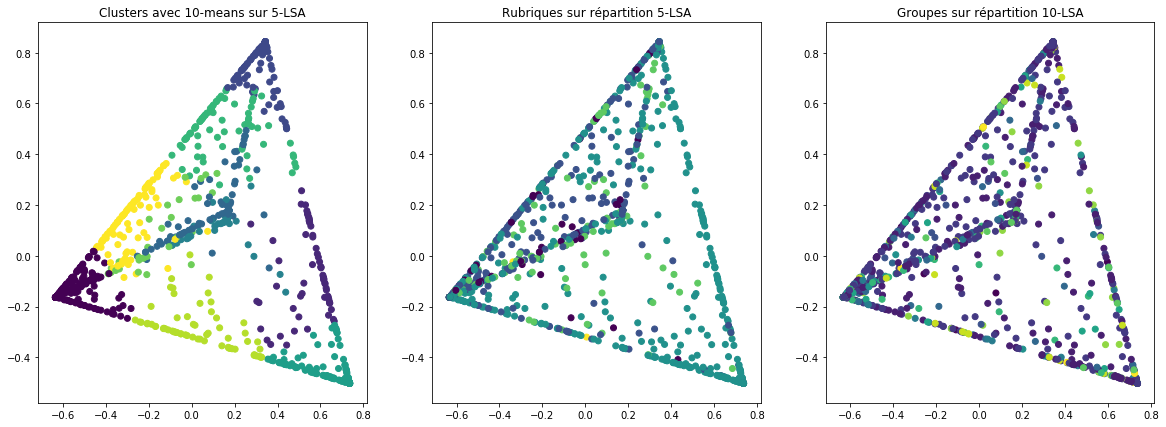

In [26]:
# Clusering
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_lda[:,0], reduced_features_lda[:,1], c=kmeans_lda.predict(lda_gensim_doc_values))
axes[1].scatter(reduced_features_lda[:,0], reduced_features_lda[:,1], c=rubint)
axes[2].scatter(reduced_features_lda[:,0], reduced_features_lda[:,1], c=groupint)
axes[0].set_title("Clusters avec {}-means sur {}-LSA".format(k_kmeans_lda,n_topics_lda));
axes[1].set_title("Rubriques sur répartition {}-LSA".format(n_topics_lda));
axes[2].set_title("Groupes sur répartition {}-LSA".format(k_kmeans_lsa,n_topics_lda));

In [27]:
from umap import UMAP
embedding = UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(lda_gensim_doc_values)

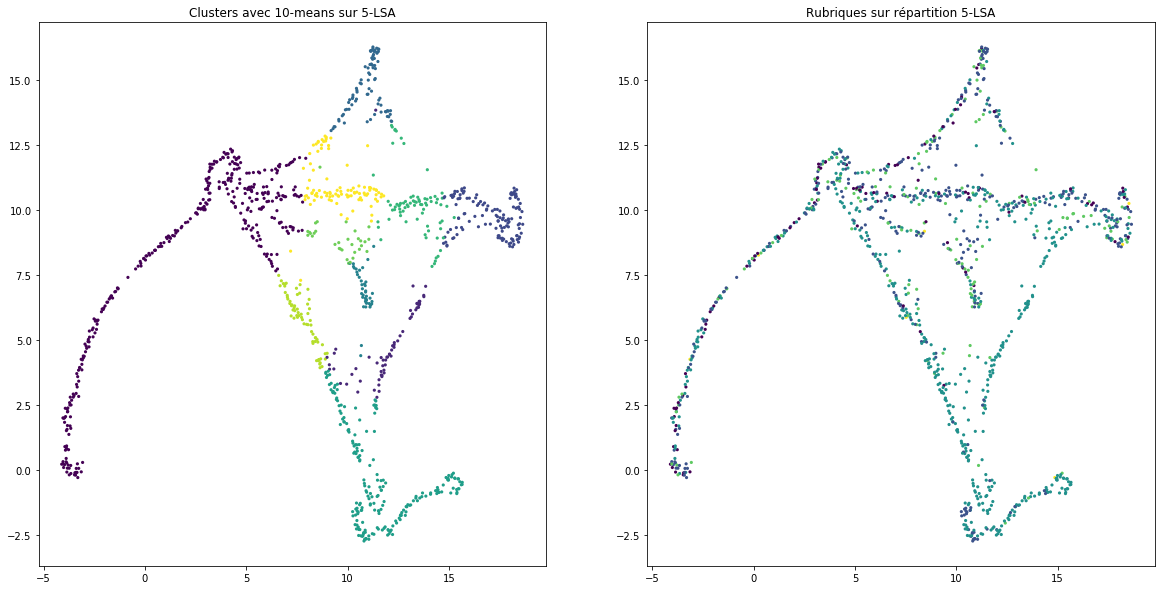

In [28]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(embedding[:, 0], embedding[:, 1], 
    c = kmeans_lda.predict(lda_gensim_doc_values),
    s = 10, # size
    edgecolor='none')
axes[1].scatter(embedding[:, 0], embedding[:, 1], 
    c = rubint,
    s = 10, # size
    edgecolor='none')
axes[0].set_title("Clusters avec {}-means sur {}-LSA".format(k_kmeans_lda,n_topics_lda));
axes[1].set_title("Rubriques sur répartition {}-LSA".format(n_topics_lda));

# D Distances entre députés

In [52]:
# Fonction calculant les distances entre lettres
# from scipy.spatial import distance_matrix
from scipy.spatial import distance


def matrix_distances(docs_vec,maxd = 100):
    """ docs_vec : les vecteurs de chaque document
        maxd : nombre maximal de documents dans la matrice
        retourne la matrice des distances 
    """
    return np.array([[dist(docs_vec[i],docs_vec[j]) for i in range(maxd)] for j in range(maxd)])
                    
# Ne sert plus
# def matrix_index(p,n):
#     """Return the index of pos p in a n*n matrix"""
#     return (p//n,p%n)

def dist(veca,vecb):
    return distance.cosine(veca,vecb)

def pair_distances(docs_vec,maxd = 100):
    """
    retourne les paires de docments avec leur distances correspondances"""
    return pd.DataFrame([(i,j,dist(docs_vec[i],docs_vec[j])) for i in range(maxd) for j in range(i)],columns = ['a','b','val']).sort_values(by = 'val').reset_index(drop = True)

def compare_corpus(padi,corpus,idx):
    """Montre les deux documents du corpus correspondant à l'indice demandé"""
    a,b,v = padi.loc[idx,]
    print("Lien {} de valeur {} :".format(idx,v))
    print(corpus.values[[int(a),int(b)]])

Lien 0 de valeur 0.009708737864077666 :
["mme barbara pompili attire attention mme ministre solidarité santé recherche cystite interstitiel . maladie vessie se révéler souvent handicapant fort douleur qu' pouvoir causer . environ 10 000 personne atteindre france . cause pathologie restent jour inconnu . diagnostic ne se effectue souvent élimination . conséquence , traitement médical souvent inefficace patient se trouver situation errance médical . apparaître nécessaire , traiter maladie , stimuler recherche scientifique , notamment cause pathologie . faciliter diagnostic , protocole diagnostic précis pouvoir défini , notamment détecter présence substance appelée « facteur antiprolifératif » , présente uniquement patient atteindre maladie . protocole pouvoir effet permettr éviter patient subir examen invasif douloureux . sensibilisation médecin , généraliste spécialiste , reste parfois faible . conséquence maladie devoir également appeler réponse pouvoir public , tant pouvoir lourder vi

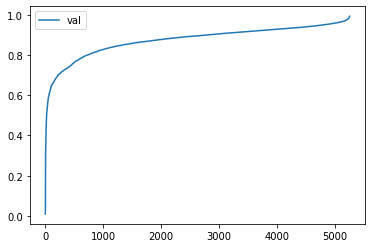

In [30]:
# Clacul avec les features du tf
vc = tf.toarray()
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,0)

Lien 0 de valeur 0.04531302835301543 :
["m. loïc dombreval attire attention mme ministre travail situation filière yachting côte azur difficulté économique qu' traverse . rappeler secteur grand plaisance représente atout majeur façade méditerranéen france , 70 pourcent quelque 6 300 yacht exister monde y transiter . or obligation affiliation régime sécurité social marin équipage plaisance professionnel ( enim ) résident partie année france embarquer navire pavillon étranger union européen ( 2 degré article l. 5551 - 1 code transport ) , niveau charge social afférer élevé beaucoup pays , créer distorsion concurrence dommageable filière . côte azur chance compter parmi entreprise chantier majeur mondiau refaire réparation yacht , contexte , mission régulation état apparaître essentiel assurer convergence social niveau européen . , souhaite large champ concertation action ouvrir faveur concurrence loyal sein secteur . demande bien vouloir informer intention gouvernement afin pallier situa

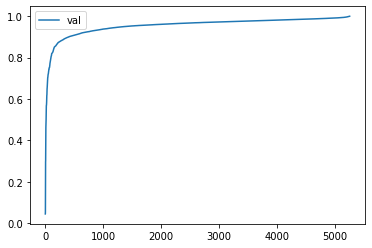

In [31]:
# Clacul avec les features du tfidf
vc = tfidf.toarray()
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,0)

Lien 98 de valeur 0.00021525767314201083 :
['m. nicolas dupont - aignan appeler attention mme ministre solidarité santé maladie urologique invalidant , « cystite interstitiel » , appelée « syndrome vessie douloureux » . faute formation médecin pathologie , porteur , homme femme , vivre errance diagnostic année , affronter souffrance physique intolérable désagrément social isoler pénaliser professionnellement . 50 pourcent patient se sentir déprimer taux suicide 4 élevé reste population . maladie , dire « rare » , touch néanmoins 10 000 personne france , probablement on comptabilise celle celui ne diagnostiquer . lorsque , élimination résultat négatif test cytobactériologique urine , diagnostic cystite interstitiel poser , seul traitement proposer patient onéreux non rembourser assurance maladie . regrouper sein association aecci ( agir ensemble cystite interstitiel ) , malade souhaitent sortir prison silence demander gouvernement encourager corps médical français se rapprocher étude re

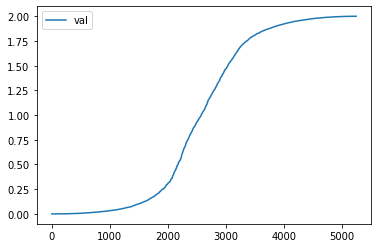

In [33]:
# Clacul avec les reduced features du tfidf
k_reduce = 10
reduced_features = pca.fit_transform(tfidf.toarray())
pca = PCA(n_components=k_reduce, random_state=random_state)
vc = reduced_features
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,98)

Lien 5 de valeur 0.006726452319011811 :
["m. sébastien huyghe attire attention mme ministre solidarité santé cystite interstitiel . cystite interstitiel , nommer également syndrome vessie douloureux , maladie chronique vessie se traduire affection urologique rare invalidant . france près 10 000 personne souffrir symptôme maladie . cystite interstitiel touch majorité femme impact quotidien malade tant plan physiologique , psychologique social . actuellement , médecine n' mesure guérir maladie s' existe moyen soulager douleur patient limiter envie uriner prise anti - inflammatoire , antispasmodique antidépresseur . homonyme bactérien , cause cystite interstitiel , n' connaître nécessit bien souvent quatre cinq an diagnostiquer autant traitement optimal pouvoir prodiguer . aujourd'hui , changement traitement régulier se avère nécessaire , notamment raison risque résistance produit organisme . demande gouvernement entend prendre mesure rapides afin favoriser recherche cause traitement cyst

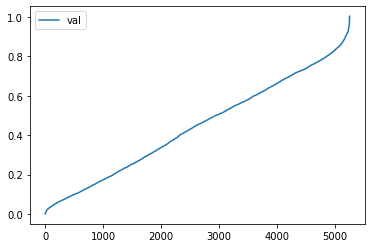

In [34]:
# Clacul avec les le LSA
vc = lsa_topics
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,5)

In [35]:
# Clacul avec le nmf (pas encore car pas trouvé de matrices docs)
# vc = nmf.components_.T
# padi = pair_distances(vc,103)
# padi.plot(y='val')
# compare_corpus(padi,corpus,0)

Lien 0 de valeur -2.220446049250313e-16 :
["mme jeanine dubié attire attention mme ministre solidarité santé prise charge maladie lyme . maladie lyme borréliose lyme suscite inquiétude croissant partie population français . effet , transmettre < em > via</em > morsure tique infecté , maladie lyme pouvoir entraîner complication grave n' soigner temps . fort expansion , touche officiellement 27 000 nouveau personne année france certain association estimer chiffre réalité bien supérieur , ordre 10 . afin mieux répondre besoin prise charge patient , plan national lutte maladie lyme lancer gouvernement 29 septembre 2016 , reconnaître enfin existence véritable enjeu santé public . prévoir renforcer outil prévention information développer recherche maladie . comité pilotage accueillir association patient devoir se réunir décliner mesure concret ensemble territoire élaborer protocole national diagnostic soin . , 26 octobre 2017 , académie médecine préciser position maladie « dénoncer tromperie

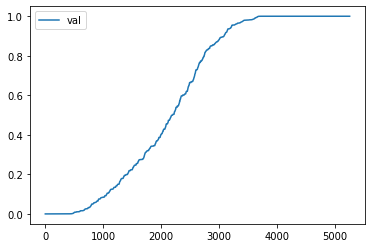

In [36]:
# Clacul avec le lda
vc = lda_gensim_doc_values
padi = pair_distances(vc,103)
padi.plot(y='val')
compare_corpus(padi,corpus,0)

# E. Tests avec des textes choisis

In [99]:
np.zeros_like([[0,1],[1,0]])

array([[0, 0],
       [0, 0]])

In [101]:
# Choix des documents
dfhi = dfh.reset_index(drop=True)
l_lyme = dfhi[dfhi.titre.str.contains('lyme')&dfhi.titre.str.contains('lutte')&dfhi.titre.str.contains('maladie')].head(3)
l_front = dfhi[dfhi.titre.str.contains('frontalier')&dfhi.titre.str.contains('travailleur')]
l_ha = dfhi.loc[[4]]
lettres_choisies= pd.concat([l_lyme,l_front,l_ha])

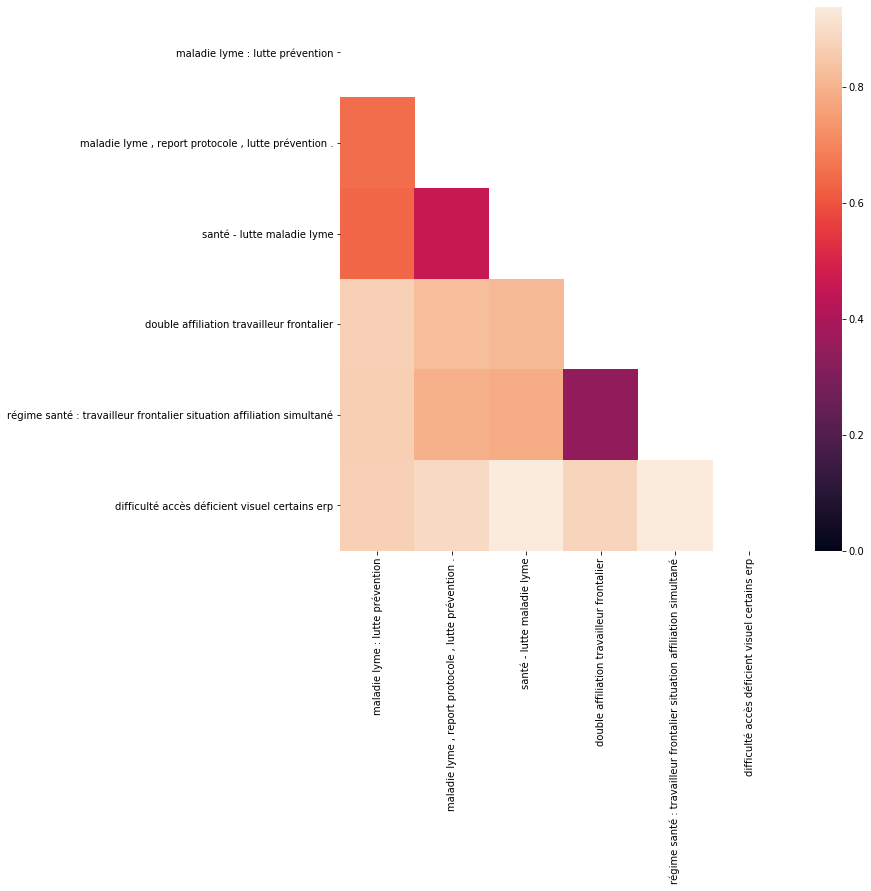

In [104]:
# Brut tf
docs_choisis_tf = tf.toarray()[lettres_choisies.index]
matrix_choisie_tf = matrix_distances(docs_choisis_tf,6)

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_tf) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_tf,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

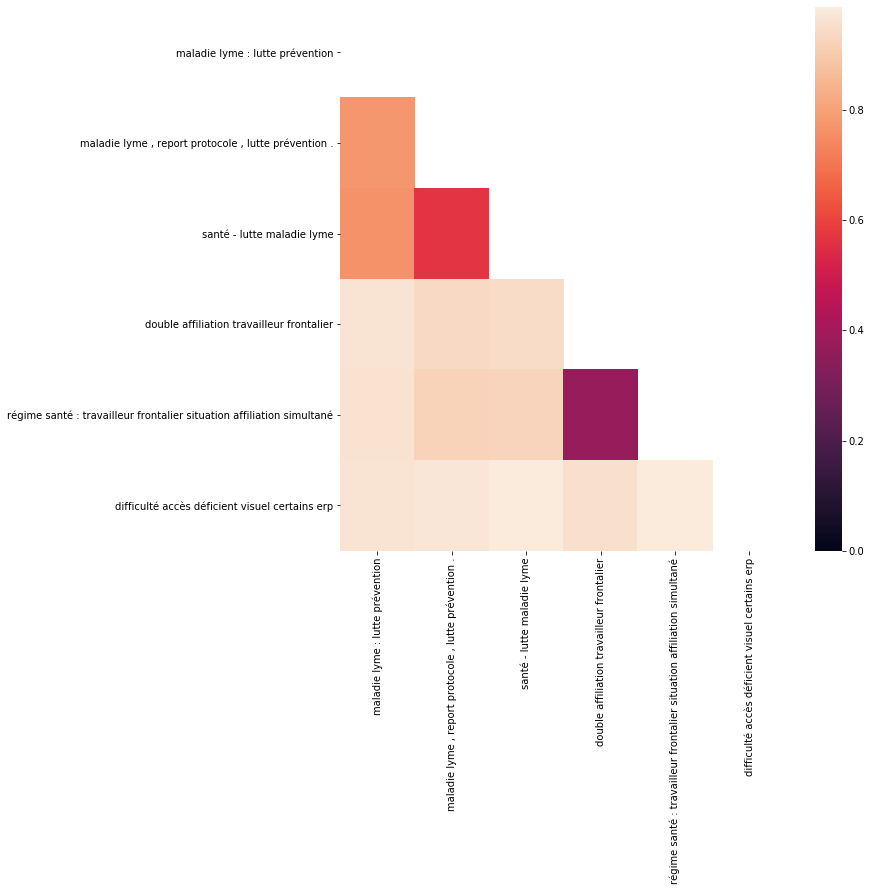

In [103]:
# Brut tfidf
docs_choisis_tfidf = tfidf.toarray()[lettres_choisies.index]
matrix_choisie_tfidf = matrix_distances(docs_choisis_tfidf,6)

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_tfidf) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_tfidf,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

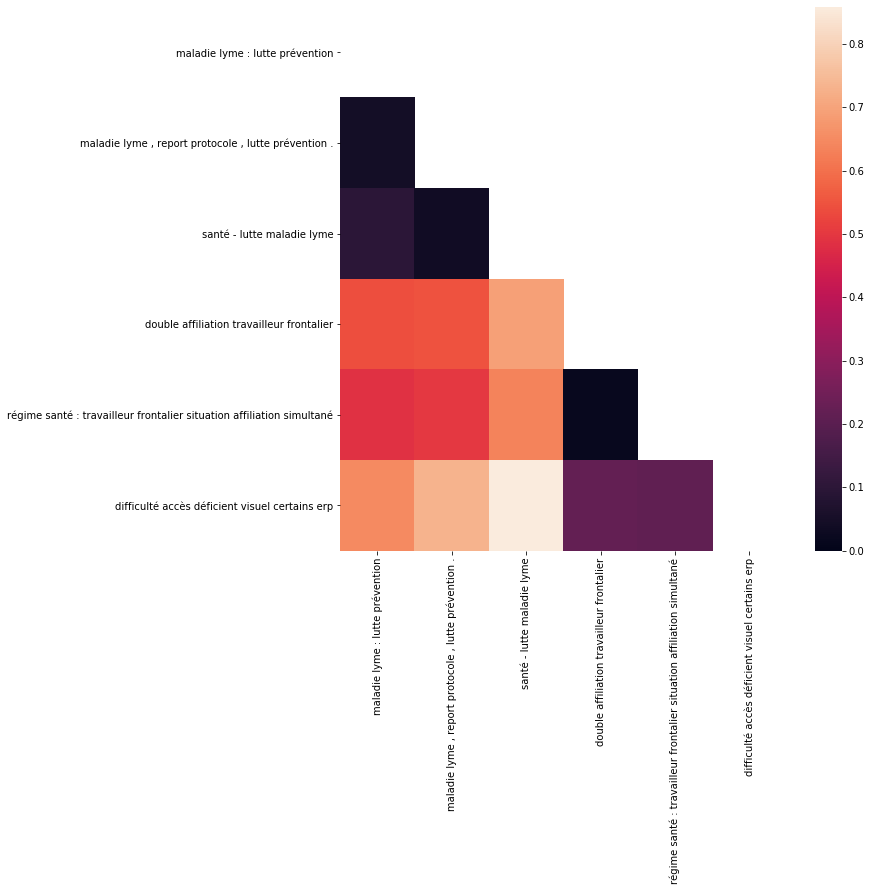

In [102]:
# LSA
docs_choisis_lsa = lsa_topics[lettres_choisies.index]
matrix_choisie_lsa = matrix_distances(docs_choisis_lsa,6)

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_lsa) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_lsa,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

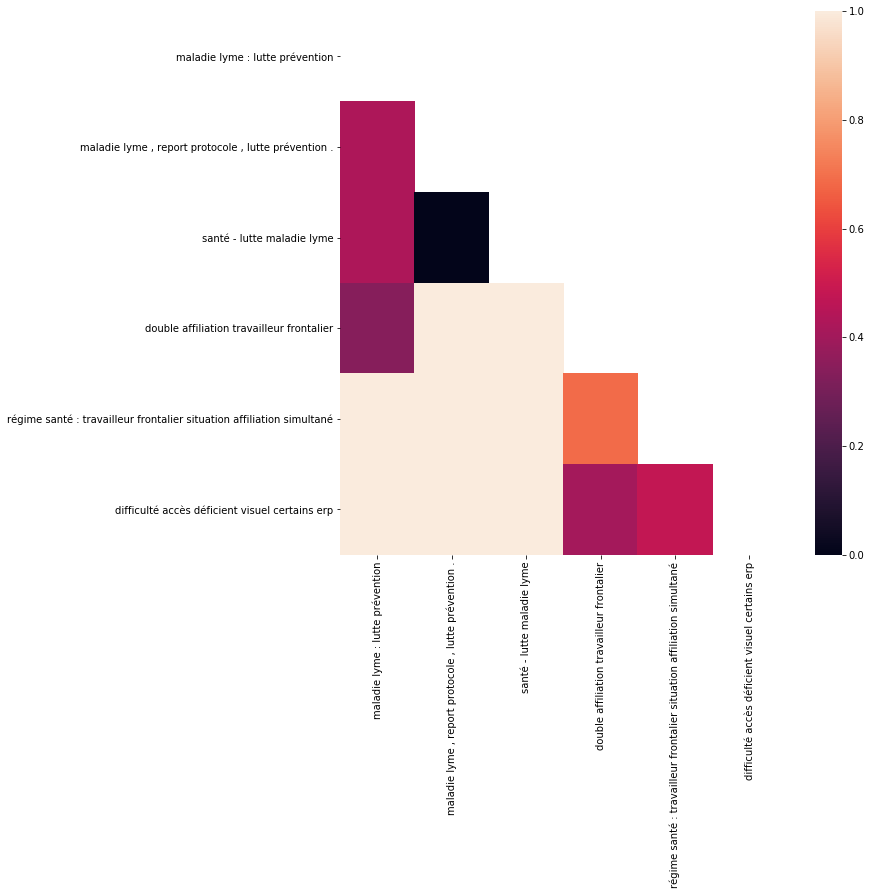

In [106]:
# LDA
docs_choisis_lda = lda_gensim_doc_values[lettres_choisies.index]
matrix_choisie_lda = matrix_distances(docs_choisis_lda,6)

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_lda) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_lda,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);